# 📊 Korelacja: Ceny Nieruchomości vs Miasto 15-minutowe

Analiza zależności między dostępnością usług (indeks 15-min) a cenami nieruchomości.

**Pytania badawcze:**
- Czy najdroższe jednostki mają lepszą dostępność usług?
- Jaki % najdroższych jednostek pokrywa się z najbardziej "15-minutowymi"?
- Jaka jest korelacja między ceną a % pełnego pokrycia?

---

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

CRS_METRIC = "EPSG:2180"
MIN_TRANSACTIONS = 10
MIN_PRICE = 6000

print("✅ Biblioteki załadowane")

✅ Biblioteki załadowane


## 1. Wczytanie Danych

In [10]:
# Wczytaj dane 15-minutowego miasta
print("📂 Wczytywanie danych...")

try:
    units_15min = gpd.read_file('data/jednostki_15_min_wyniki.gpkg')
    units_15min = units_15min.to_crs(CRS_METRIC)
    print(f"   ✅ Jednostki 15-min: {len(units_15min)}")
except:
    raise FileNotFoundError("Uruchom najpierw: miasto_15_minut_regiony.ipynb")

📂 Wczytywanie danych...
   ✅ Jednostki 15-min: 111


In [11]:
# Wczytaj dane transakcji
gdf1 = gpd.read_file('data/raw/transactions_pierwotny_2023_2025_raw.geojson')
gdf2 = gpd.read_file('data/raw/transactions_wtorny_2023_2025_raw.geojson')

gdf_trans = pd.concat([gdf1, gdf2], ignore_index=True)
gdf_trans = gpd.GeoDataFrame(gdf_trans, geometry='geometry', crs=gdf1.crs)
gdf_trans = gdf_trans.to_crs(CRS_METRIC)

# Czyszczenie
gdf_trans = gdf_trans[gdf_trans['sr_cena_m2'] >= MIN_PRICE]

# Agregacja
agg_trans = gdf_trans.groupby('nazwa_jedn').agg(
    transakcje=('lkl_count', 'sum'),
    sr_cena_m2=('sr_cena_m2', 'mean')
).reset_index()

agg_trans = agg_trans[agg_trans['transakcje'] >= MIN_TRANSACTIONS]
agg_trans['sr_cena_m2'] = agg_trans['sr_cena_m2'].round(0).astype(int)

print(f"   ✅ Transakcje: {len(agg_trans)} jednostek (po czyszczeniu)")

   ✅ Transakcje: 105 jednostek (po czyszczeniu)


In [12]:
# Połącz dane
merged = units_15min.merge(agg_trans, on='nazwa_jedn', how='inner')

print(f"\n📊 Połączone dane: {len(merged)} jednostek")


📊 Połączone dane: 104 jednostek


## 2. Rankingi - TOP 20% i BOTTOM 20% (z remisami)

In [13]:
# Oblicz percentyle Z UWZGLĘDNIENIEM REMISÓW
# Jeśli wiele jednostek ma 100%, WSZYSTKIE wchodzą do TOP

n = len(merged)
top_n = max(1, int(n * 0.2))  # Bazowe TOP 20%

# Sortuj
merged_sorted_price = merged.sort_values('sr_cena_m2', ascending=False)
merged_sorted_15min = merged.sort_values('full_coverage_pct', ascending=False)

# === TOP NAJDROŻSZE ===
# Znajdź próg cenowy na pozycji 20%
price_threshold_top = merged_sorted_price.iloc[min(top_n-1, n-1)]['sr_cena_m2']
# Weź WSZYSTKIE jednostki >= ten próg (uwzględnia remisy)
top_expensive = set(merged[merged['sr_cena_m2'] >= price_threshold_top]['nazwa_jedn'])

# === BOTTOM NAJTAŃSZE ===
price_threshold_bottom = merged_sorted_price.iloc[max(0, n-top_n)]['sr_cena_m2']
bottom_cheap = set(merged[merged['sr_cena_m2'] <= price_threshold_bottom]['nazwa_jedn'])

# === TOP NAJBARDZIEJ 15-MINUTOWE ===
# KLUCZOWA ZMIANA: jeśli więcej niż 20% ma 100%, wszystkie 100% wchodzą
coverage_threshold_top = merged_sorted_15min.iloc[min(top_n-1, n-1)]['full_coverage_pct']
top_15min = set(merged[merged['full_coverage_pct'] >= coverage_threshold_top]['nazwa_jedn'])

# === BOTTOM NAJMNIEJ 15-MINUTOWE ===
coverage_threshold_bottom = merged_sorted_15min.iloc[max(0, n-top_n)]['full_coverage_pct']
bottom_15min = set(merged[merged['full_coverage_pct'] <= coverage_threshold_bottom]['nazwa_jedn'])

print(f"📊 Analiza TOP/BOTTOM 20% (bazowo {top_n} jednostek, z remisami):")
print(f"\n   💰 Najdroższe (>={price_threshold_top:,} zł): {len(top_expensive)} jednostek")
print(f"   💵 Najtańsze (<={price_threshold_bottom:,} zł): {len(bottom_cheap)} jednostek")
print(f"   🟢 Najbardziej 15-min (>={coverage_threshold_top:.0f}%): {len(top_15min)} jednostek")
print(f"   🔴 Najmniej 15-min (<={coverage_threshold_bottom:.0f}%): {len(bottom_15min)} jednostek")
print(f"\n   ℹ️ Remisy uwzględnione - może być więcej jednostek niż 20%")

📊 Analiza TOP/BOTTOM 20% (bazowo 20 jednostek, z remisami):

   💰 Najdroższe (>=16,007 zł): 20 jednostek
   💵 Najtańsze (<=11,437 zł): 20 jednostek
   🟢 Najbardziej 15-min (>=100%): 53 jednostek
   🔴 Najmniej 15-min (<=61%): 20 jednostek

   ℹ️ Remisy uwzględnione - może być więcej jednostek niż 20%


In [14]:
# Pokrywanie się kategorii
overlap_expensive_15min = top_expensive & top_15min
overlap_cheap_bad15min = bottom_cheap & bottom_15min

# Oblicz % na podstawie mniejszego zbioru
pct_expensive_15min = len(overlap_expensive_15min) / min(len(top_expensive), len(top_15min)) * 100
pct_cheap_bad15min = len(overlap_cheap_bad15min) / min(len(bottom_cheap), len(bottom_15min)) * 100

print("="*60)
print("🔗 POKRYWANIE SIĘ KATEGORII:")
print("="*60)

print(f"\n💰🟢 Najdroższe ∩ Najbardziej 15-min:")
print(f"   {len(overlap_expensive_15min)} jednostek wspólnych")
print(f"   = {pct_expensive_15min:.1f}% pokrycia")
if overlap_expensive_15min:
    print(f"   Jednostki: {', '.join(sorted(list(overlap_expensive_15min))[:5])}...")

print(f"\n💵🔴 Najtańsze ∩ Najmniej 15-min:")
print(f"   {len(overlap_cheap_bad15min)} jednostek wspólnych")
print(f"   = {pct_cheap_bad15min:.1f}% pokrycia")
if overlap_cheap_bad15min:
    print(f"   Jednostki: {', '.join(sorted(list(overlap_cheap_bad15min))[:5])}...")

🔗 POKRYWANIE SIĘ KATEGORII:

💰🟢 Najdroższe ∩ Najbardziej 15-min:
   15 jednostek wspólnych
   = 75.0% pokrycia
   Jednostki: Grzegórzki Wschód, Grzegórzki Zachód, Kazimierz, Kleparz, Mateczny...

💵🔴 Najtańsze ∩ Najmniej 15-min:
   9 jednostek wspólnych
   = 45.0% pokrycia
   Jednostki: Kostrze, Mogiła, Olszyny, Opatkowice Wschód, Opatkowice Zachód...


In [15]:
# Tabele rankingowe - TOP najdroższe
print(f"\n🏆 TOP NAJDROŻSZE JEDNOSTKI ({len(top_expensive)}):")
print("="*70)
for i, row in enumerate(merged[merged['nazwa_jedn'].isin(top_expensive)].sort_values('sr_cena_m2', ascending=False).itertuples(), 1):
    is_15min = "🟢" if row.nazwa_jedn in top_15min else "  "
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.sr_cena_m2:,} zł/m² | {row.full_coverage_pct:.0f}% 15min {is_15min}")


🏆 TOP NAJDROŻSZE JEDNOSTKI (20):
 1. Stradom                        | 23,205 zł/m² | 100% 15min 🟢
 2. Stare Miasto                   | 20,223 zł/m² | 100% 15min 🟢
 3. Nowy Świat                     | 20,071 zł/m² | 100% 15min 🟢
 4. Wesoła Zachód                  | 18,563 zł/m² | 100% 15min 🟢
 5. Piasek Południe                | 18,477 zł/m² | 100% 15min 🟢
 6. Warszawskie                    | 18,365 zł/m² | 100% 15min 🟢
 7. Grzegórzki Zachód              | 17,982 zł/m² | 100% 15min 🟢
 8. Grzegórzki Wschód              | 17,584 zł/m² | 100% 15min 🟢
 9. Wesoła Wschód                  | 17,582 zł/m² | 100% 15min 🟢
10. Zwierzyniec                    | 17,567 zł/m² | 84% 15min   
11. Półwsie Zwierzynieckie         | 17,542 zł/m² | 100% 15min 🟢
12. Bronowice Małe Południe        | 17,442 zł/m² | 93% 15min   
13. Małe Błonia                    | 16,983 zł/m² | 93% 15min   
14. Zabłocie                       | 16,754 zł/m² | 72% 15min   
15. Kleparz                        | 16,741 zł/m² | 100%

In [16]:
# TOP najbardziej 15-minutowe
print(f"\n🟢 TOP NAJBARDZIEJ 15-MINUTOWE ({len(top_15min)}):")
print("="*70)
for i, row in enumerate(merged[merged['nazwa_jedn'].isin(top_15min)].sort_values('full_coverage_pct', ascending=False).itertuples(), 1):
    is_exp = "💰" if row.nazwa_jedn in top_expensive else "  "
    print(f"{i:2}. {row.nazwa_jedn:30} | {row.full_coverage_pct:.0f}% 15min | {row.sr_cena_m2:,} zł/m² {is_exp}")


🟢 TOP NAJBARDZIEJ 15-MINUTOWE (53):
 1. Azory Wschód                   | 100% 15min | 12,629 zł/m²   
 2. Nowa Wieś Południe             | 100% 15min | 16,007 zł/m² 💰
 3. Olsza                          | 100% 15min | 12,354 zł/m²   
 4. Osiedle Albertyńskie           | 100% 15min | 11,680 zł/m²   
 5. Osiedle Oficerskie             | 100% 15min | 13,973 zł/m²   
 6. Piasek Południe                | 100% 15min | 18,477 zł/m² 💰
 7. Piasek Północ                  | 100% 15min | 16,222 zł/m² 💰
 8. Prądnik Biały Południe         | 100% 15min | 12,404 zł/m²   
 9. Prądnik Biały Północ           | 100% 15min | 13,908 zł/m²   
10. Półwsie Zwierzynieckie         | 100% 15min | 17,542 zł/m² 💰
11. Rakowice                       | 100% 15min | 14,126 zł/m²   
12. Sportowe - Zielone             | 100% 15min | 11,274 zł/m²   
13. Spółdzielcze - Kolorowe        | 100% 15min | 11,437 zł/m²   
14. Stalowe - Willowe - Wandy      | 100% 15min | 11,556 zł/m²   
15. Stare Miasto                   | 100% 1

## 3. Analiza Korelacji

In [17]:
# Korelacje
x = merged['sr_cena_m2'].values
y = merged['full_coverage_pct'].values

pearson_r, pearson_p = stats.pearsonr(x, y)
spearman_r, spearman_p = stats.spearmanr(x, y)

print("📈 ANALIZA KORELACJI:")
print("="*50)
print(f"\n   Pearson r:  {pearson_r:.3f} (p-value: {pearson_p:.4f})")
print(f"   Spearman ρ: {spearman_r:.3f} (p-value: {spearman_p:.4f})")

if abs(pearson_r) < 0.3:
    strength = "słaba"
elif abs(pearson_r) < 0.5:
    strength = "umiarkowana"
elif abs(pearson_r) < 0.7:
    strength = "silna"
else:
    strength = "bardzo silna"

direction = "pozytywna" if pearson_r > 0 else "negatywna"
significant = "istotna statystycznie" if pearson_p < 0.05 else "nieistotna"

print(f"\n   Interpretacja: {strength} korelacja {direction}, {significant}")

📈 ANALIZA KORELACJI:

   Pearson r:  0.366 (p-value: 0.0001)
   Spearman ρ: 0.325 (p-value: 0.0008)

   Interpretacja: umiarkowana korelacja pozytywna, istotna statystycznie


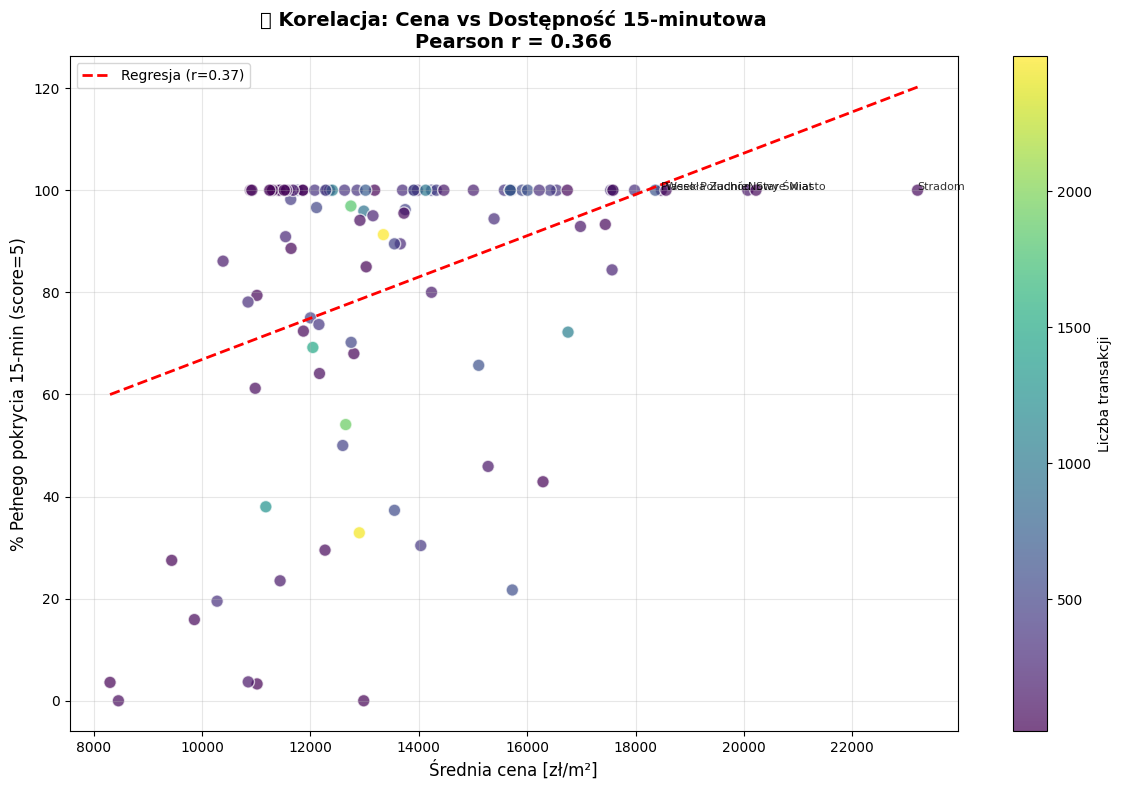

💾 Zapisano: data/wykres_korelacja_cena_15min.png


In [18]:
# Wykres scatter z linią regresji
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(x, y, c=merged['transakcje'], cmap='viridis', s=80, alpha=0.7, edgecolor='white')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Regresja (r={pearson_r:.2f})')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Liczba transakcji', fontsize=10)

for _, row in merged.nlargest(5, 'sr_cena_m2').iterrows():
    ax.annotate(row['nazwa_jedn'], (row['sr_cena_m2'], row['full_coverage_pct']), fontsize=8, alpha=0.8)

ax.set_xlabel('Średnia cena [zł/m²]', fontsize=12)
ax.set_ylabel('% Pełnego pokrycia 15-min (score=5)', fontsize=12)
ax.set_title(f'📊 Korelacja: Cena vs Dostępność 15-minutowa\nPearson r = {pearson_r:.3f}', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/wykres_korelacja_cena_15min.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/wykres_korelacja_cena_15min.png")

## 4. Mapy Side-by-Side

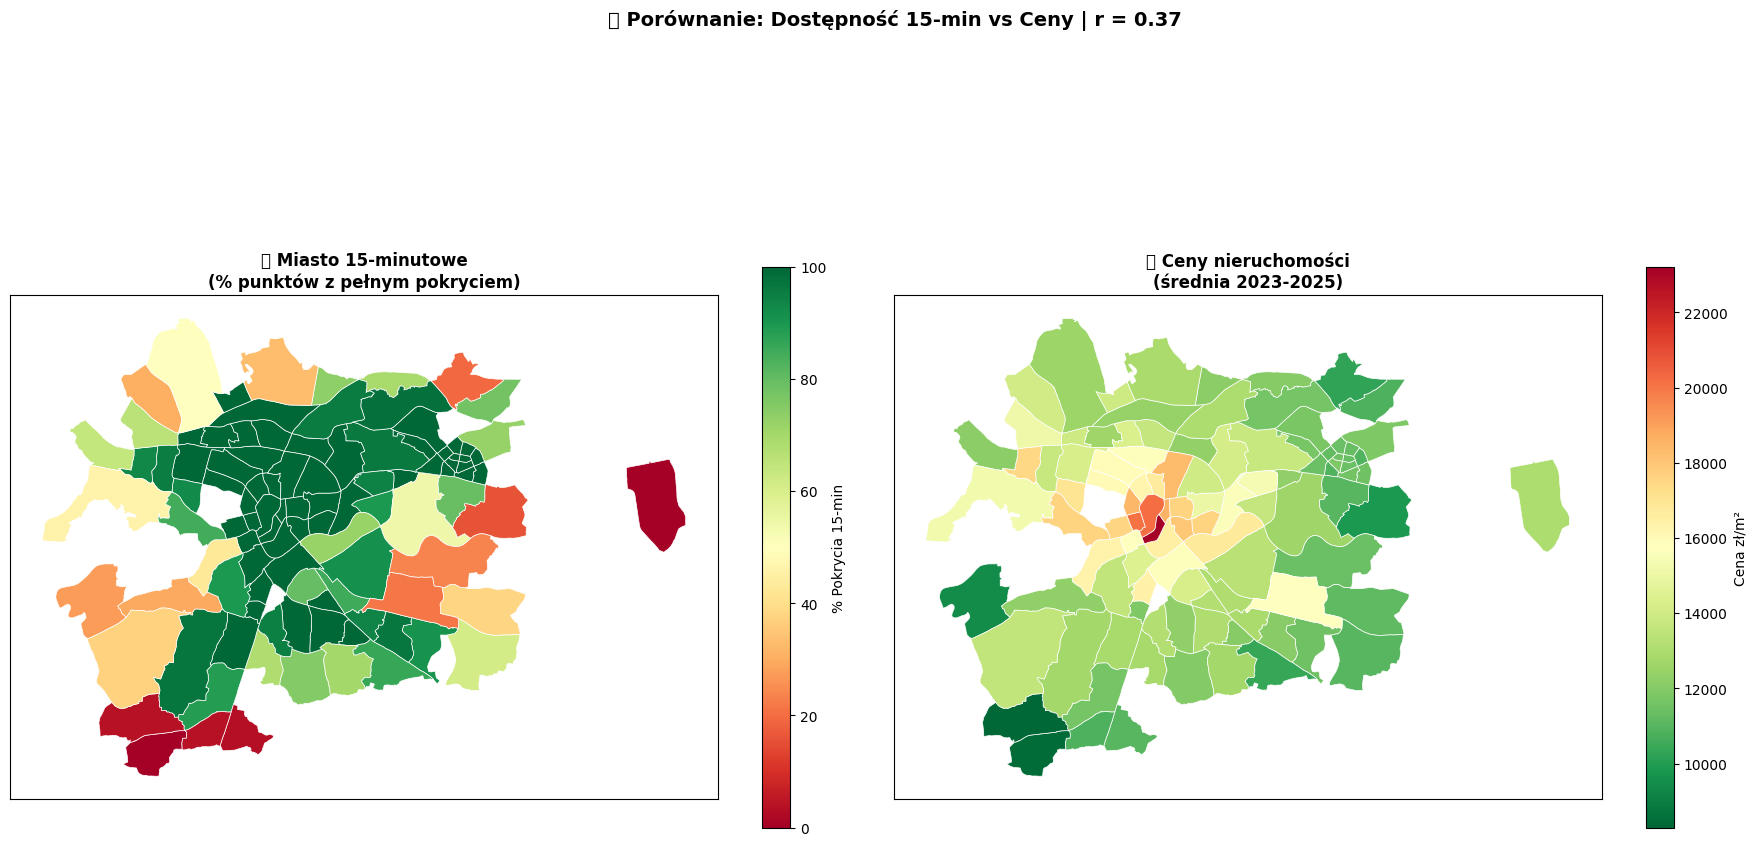

💾 Zapisano: data/mapa_porownanie_15min_ceny.png


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Mapa 1: % Pełnego pokrycia 15-min
ax1 = axes[0]
merged.plot(ax=ax1, column='full_coverage_pct', cmap='RdYlGn', vmin=0, vmax=100,
            edgecolor='white', linewidth=0.5, legend=True,
            legend_kwds={'label': '% Pokrycia 15-min', 'shrink': 0.6})
ax1.set_title('🏙️ Miasto 15-minutowe\n(% punktów z pełnym pokryciem)', fontsize=12, fontweight='bold')
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

# Mapa 2: Ceny
ax2 = axes[1]
merged.plot(ax=ax2, column='sr_cena_m2', cmap='RdYlGn_r', edgecolor='white', linewidth=0.5,
            legend=True, legend_kwds={'label': 'Cena zł/m²', 'shrink': 0.6})
ax2.set_title('🏠 Ceny nieruchomości\n(średnia 2023-2025)', fontsize=12, fontweight='bold')
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])

fig.suptitle(f'📊 Porównanie: Dostępność 15-min vs Ceny | r = {pearson_r:.2f}', fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('data/mapa_porownanie_15min_ceny.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/mapa_porownanie_15min_ceny.png")

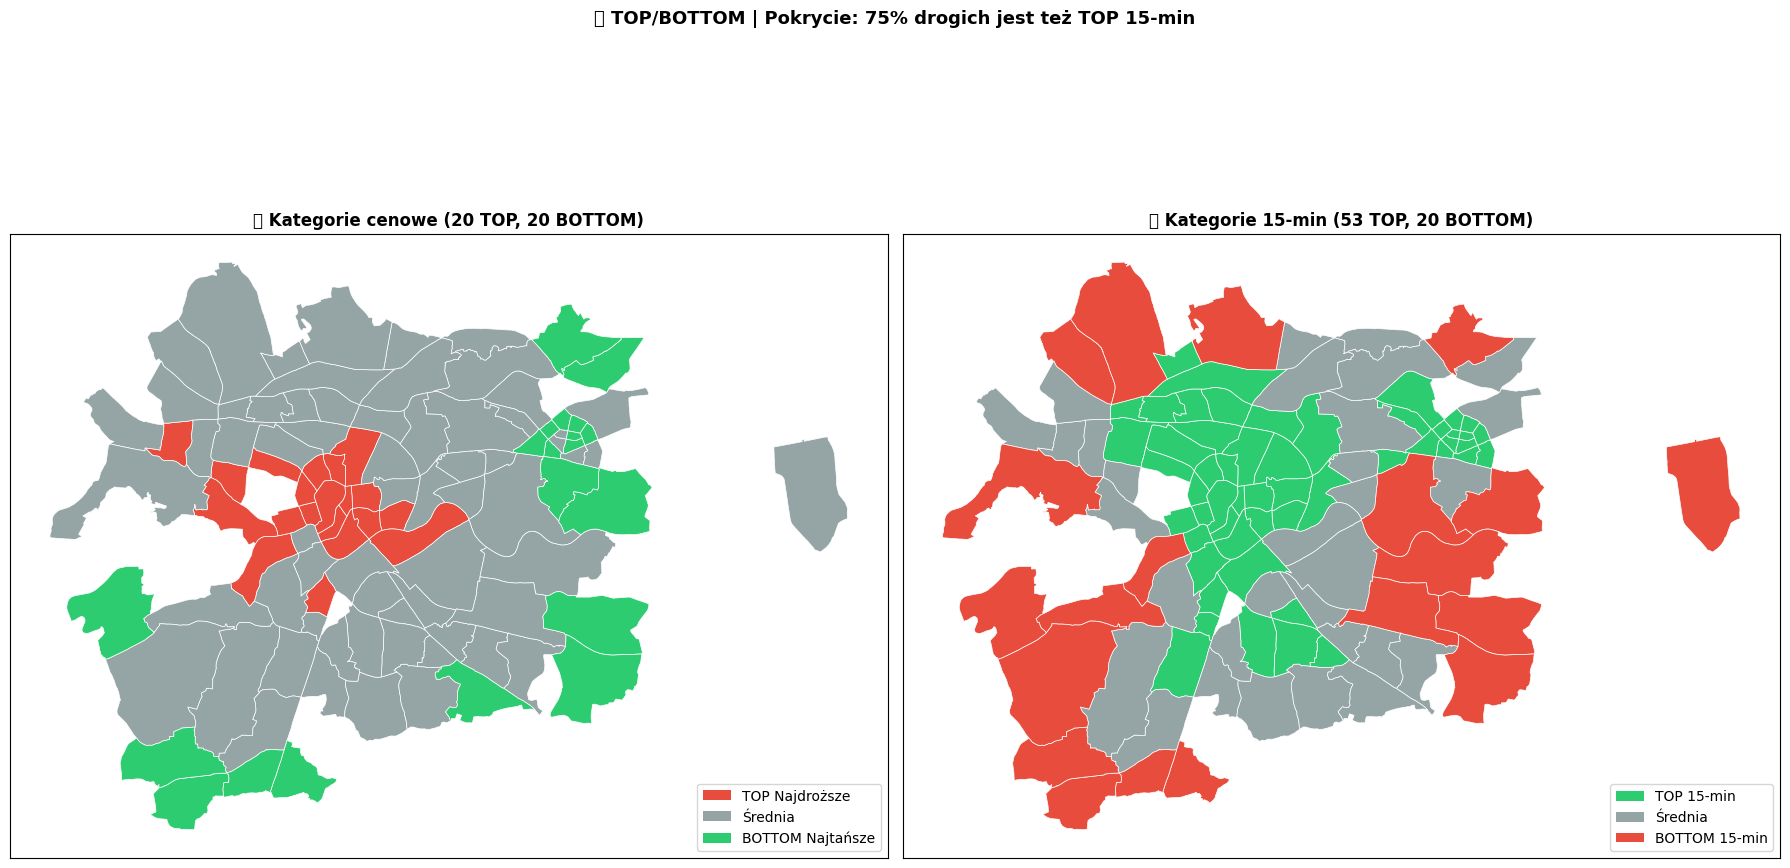

💾 Zapisano: data/mapa_kategorie_top_bottom.png


In [20]:
# Mapa kategorii TOP/BOTTOM
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

merged['kat_cena'] = 'Średnia'
merged.loc[merged['nazwa_jedn'].isin(top_expensive), 'kat_cena'] = 'TOP Najdroższe'
merged.loc[merged['nazwa_jedn'].isin(bottom_cheap), 'kat_cena'] = 'BOTTOM Najtańsze'

merged['kat_15min'] = 'Średnia'
merged.loc[merged['nazwa_jedn'].isin(top_15min), 'kat_15min'] = 'TOP 15-min'
merged.loc[merged['nazwa_jedn'].isin(bottom_15min), 'kat_15min'] = 'BOTTOM 15-min'

colors_cena = {'TOP Najdroższe': '#e74c3c', 'Średnia': '#95a5a6', 'BOTTOM Najtańsze': '#2ecc71'}
colors_15min = {'TOP 15-min': '#2ecc71', 'Średnia': '#95a5a6', 'BOTTOM 15-min': '#e74c3c'}

ax1 = axes[0]
for kat, color in colors_cena.items():
    merged[merged['kat_cena'] == kat].plot(ax=ax1, color=color, edgecolor='white', linewidth=0.5)
ax1.set_title(f'💰 Kategorie cenowe ({len(top_expensive)} TOP, {len(bottom_cheap)} BOTTOM)', fontsize=12, fontweight='bold')
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = axes[1]
for kat, color in colors_15min.items():
    merged[merged['kat_15min'] == kat].plot(ax=ax2, color=color, edgecolor='white', linewidth=0.5)
ax2.set_title(f'🏙️ Kategorie 15-min ({len(top_15min)} TOP, {len(bottom_15min)} BOTTOM)', fontsize=12, fontweight='bold')
ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])

from matplotlib.patches import Patch
legend1 = [Patch(facecolor=c, label=l) for l, c in colors_cena.items()]
legend2 = [Patch(facecolor=c, label=l) for l, c in colors_15min.items()]
ax1.legend(handles=legend1, loc='lower right')
ax2.legend(handles=legend2, loc='lower right')

fig.suptitle(f'📊 TOP/BOTTOM | Pokrycie: {pct_expensive_15min:.0f}% drogich jest też TOP 15-min', fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('data/mapa_kategorie_top_bottom.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/mapa_kategorie_top_bottom.png")

## 5. Wykres Pokrycia Kategorii

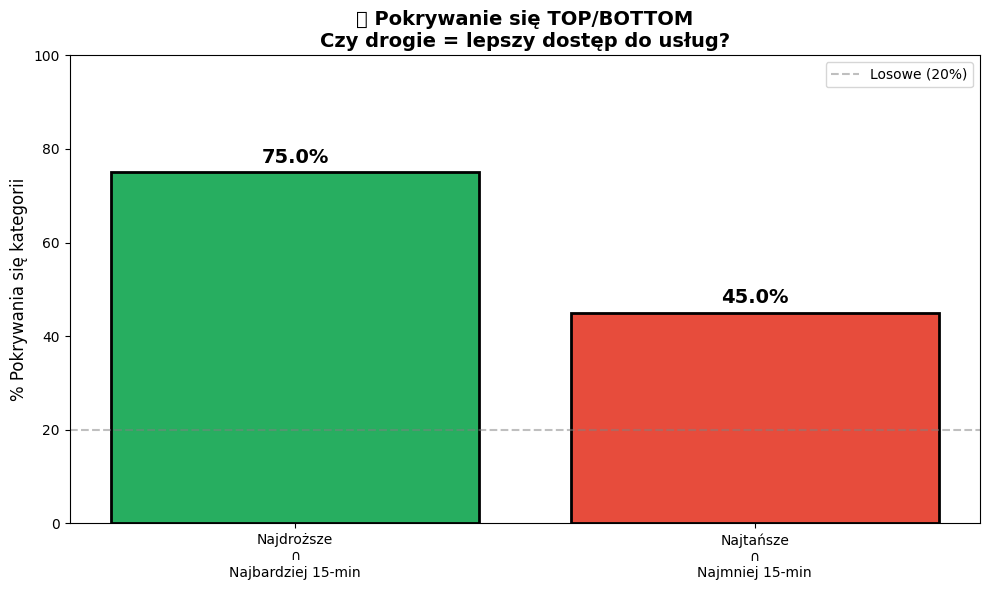

💾 Zapisano: data/wykres_overlap_kategorii.png


In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Najdroższe\n∩\nNajbardziej 15-min', 'Najtańsze\n∩\nNajmniej 15-min']
overlaps = [pct_expensive_15min, pct_cheap_bad15min]
colors = ['#27ae60', '#e74c3c']

bars = ax.bar(categories, overlaps, color=colors, edgecolor='black', linewidth=2)

for bar, val in zip(bars, overlaps):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.1f}%', ha='center', fontsize=14, fontweight='bold')

ax.set_ylabel('% Pokrywania się kategorii', fontsize=12)
ax.set_title('📊 Pokrywanie się TOP/BOTTOM\nCzy drogie = lepszy dostęp do usług?', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=20, color='gray', linestyle='--', alpha=0.5, label='Losowe (20%)')
ax.legend()

plt.tight_layout()
plt.savefig('data/wykres_overlap_kategorii.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Zapisano: data/wykres_overlap_kategorii.png")

## 6. Podsumowanie

In [22]:
print("="*70)
print("📋 PODSUMOWANIE ANALIZY")
print("="*70)

print(f"\n📊 Dane: {len(merged)} jednostek")
print(f"\n📈 Korelacja cena ↔ 15-min: r = {pearson_r:.3f} ({strength} {direction})")
print(f"\n🔗 Pokrywanie kategorii:")
print(f"   • TOP drogie ∩ TOP 15-min: {len(overlap_expensive_15min)} = {pct_expensive_15min:.1f}%")
print(f"   • BOTTOM tanie ∩ BOTTOM 15-min: {len(overlap_cheap_bad15min)} = {pct_cheap_bad15min:.1f}%")

if pct_expensive_15min > 40:
    conclusion = "SILNY związek między ceną a dostępnością"
elif pct_expensive_15min > 25:
    conclusion = "UMIARKOWANY związek"
else:
    conclusion = "SŁABY związek"

print(f"\n💡 WNIOSEK: {conclusion}")
print("="*70)

📋 PODSUMOWANIE ANALIZY

📊 Dane: 104 jednostek

📈 Korelacja cena ↔ 15-min: r = 0.366 (umiarkowana pozytywna)

🔗 Pokrywanie kategorii:
   • TOP drogie ∩ TOP 15-min: 15 = 75.0%
   • BOTTOM tanie ∩ BOTTOM 15-min: 9 = 45.0%

💡 WNIOSEK: SILNY związek między ceną a dostępnością


In [23]:
# Eksport
export_df = merged[['nazwa_jedn', 'sr_cena_m2', 'full_coverage_pct', 'avg_score', 'transakcje', 'kat_cena', 'kat_15min']]
export_df = export_df.sort_values('sr_cena_m2', ascending=False)
export_df.to_csv('data/korelacja_cena_15min.csv', index=False, encoding='utf-8-sig')
print("💾 CSV: data/korelacja_cena_15min.csv")

print("\n✅ ANALIZA ZAKOŃCZONA!")

💾 CSV: data/korelacja_cena_15min.csv

✅ ANALIZA ZAKOŃCZONA!
